### AI Study 
using many methods at once with MNIST data

In [21]:
import torch
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

#####  Hardware

In [22]:
##Hardwere
import torch
if torch.cuda.is_available() == True:
  device = 'cuda'
  templist = [1,2,3]
  templist = torch.FloatTensor(templist).to(device)
  print("Cuda torch working : ",end="")
  print(templist.is_cuda)
  print("current device no. : ",end="")
  print(torch.cuda.current_device())
  print("GPU device count : ",end="")
  print(torch.cuda.device_count())
  print("GPU name : ",end="")
  print(torch.cuda.get_device_name(0))
  print("device : ",device)
elif torch.backends.mps.is_available() == True:
  print("Apple device detected\nActivating Apple Silicon GPU")
  device = torch.device("mps")
else:
  print("cant use gpu , activating cpu")
  device = 'cpu'

Cuda torch working : True
current device no. : 0
GPU device count : 1
GPU name : NVIDIA GeForce GTX 1080
device :  cuda


##### Random Seed

In [23]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

#### Parameters

In [24]:
LR_list = [10000,100,1,1e-2,1e-4,1e-6,1e-8]
learning_rate = [1e-3]
nb_epoch = 15
batch_size = 100
drop_out_posibility = 0.3
def show_parameters():
  print("Learning list : ",LR_list)
  print("Learning rate : ",learning_rate)
  print("Nb_epoch : ",nb_epoch)
  print("Batch size : ",batch_size)
  print("dropout : ",drop_out_posibility)
show_parameters()

Learning list :  [10000, 100, 1, 0.01, 0.0001, 1e-06, 1e-08]
Learning rate :  [0.001]
Nb_epoch :  15
Batch size :  100
dropout :  0.3


##### Download MNIST data

In [25]:
mnist_train= data.MNIST(root='MNIST_data',
                        train = True, #bring train data
                        transform=transforms.ToTensor(),
                        download=True)
mnist_test = data.MNIST(root='MNIST_data',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

#### Set data loader

In [26]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, #batch size at parameters
                                          shuffle=True, #mix it up
                                          drop_last=True) #len(data)%batch = left overs shoud I drop this or not?

In [27]:

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


#### Model presets

In [28]:
##One layer model
linear1 = torch.nn.Linear(784,10,bias=True)
##Five layer model
linear51 = torch.nn.Linear(784,512,bias=True)
linear52 = torch.nn.Linear(512,512,bias=True)
linear53 = torch.nn.Linear(512,512,bias=True)
linear54 = torch.nn.Linear(512,512,bias=True)
linear55 = torch.nn.Linear(512,10,bias=True)


##Line model
relu = torch.nn.ReLU()
#dropout
dropout = torch.nn.Dropout(p=drop_out_posibility)
#loss
loss = torch.nn.CrossEntropyLoss().to(device)

models = [['1layer','SGD'],['5layer','SGD'],['1layer','Adam'],['5layer','Adam'],['5layer+drop','SGD'],['5layer+drop','Adam']]


def choose_model(LR,layer,optim):
  global model
  global optimzier
  if layer == '1layer':
    torch.nn.init.normal_(linear1.weight)
    model = torch.nn.Sequential(linear1).to(device)
    #print("layer1")
  elif layer == '5layer':
    torch.nn.init.normal_(linear51.weight)
    torch.nn.init.normal_(linear52.weight)
    torch.nn.init.normal_(linear53.weight)
    torch.nn.init.normal_(linear54.weight)
    torch.nn.init.normal_(linear55.weight)
    model = torch.nn.Sequential(linear51,relu,
                                linear52,relu,
                                linear53,relu,
                                linear54,relu,
                                linear55).to(device)
    #print("layer5")
  elif layer == '5layer+drop':
    torch.nn.init.normal_(linear51.weight)
    torch.nn.init.normal_(linear52.weight)
    torch.nn.init.normal_(linear53.weight)
    torch.nn.init.normal_(linear54.weight)
    torch.nn.init.normal_(linear55.weight)
    model = torch.nn.Sequential(linear51,relu,dropout,
                                linear52,relu,dropout,
                                linear53,relu,dropout,
                                linear54,relu,dropout,
                                linear55).to(device)
    model.train()#we need this when dropout
    #print("layer5 drop")
  else:
    print("Error : Unknown Layer option please check models list")
  if optim == 'SGD':
    optimzier = torch.optim.SGD(model.parameters(),lr=LR)
    #print("SGD")
  elif optim == 'Adam':
    optimzier = torch.optim.Adam(model.parameters(),lr=LR)
    #print("Adam")
  else:
    print("Error unknown optim option please check models list")

print("defalt")
choose_model(LR_list[0],models[0][0],models[0][1])

defalt


In [29]:
torch.nn.init.normal_(linear51.weight)
torch.nn.init.normal_(linear52.weight)
torch.nn.init.normal_(linear53.weight)
torch.nn.init.normal_(linear54.weight)
torch.nn.init.normal_(linear55.weight)
model = torch.nn.Sequential(linear51,relu,dropout,
                            linear52,relu,dropout,
                            linear53,relu,dropout,
                            linear54,relu,dropout,
                            linear55).to(device)
model.train()#we need this when dropout
optimzier = torch.optim.Adam(model.parameters(),lr=1e-3)


In [30]:
from tqdm import tqdm
batch_len = len(data_loader)

for LR in LR_list:
  for layer,optim in models:
    choose_model(LR,layer,optim)#function chooseing model
    
    for epoch in tqdm(range(nb_epoch)):
      avg_cost = 0
      for X , Y in (data_loader):
        
        #change image to 1 dim list
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)
        
        #reset grad
        optimzier.zero_grad()
        #foward
        hypothesis = model(X)
        #Error
        cost = loss(hypothesis,Y)
        # Backparopagation
        cost.backward()
        #cal weight
        optimzier.step()
        #avr cal
        avg_cost = avg_cost + cost/batch_len
    ## ACC
    with torch.no_grad():
      model.eval()
      X_test = mnist_test.test_data.view(-1,28*28).float().to(device)
      Y_test = mnist_test.test_labels.to(device)
      
      prediction = model(X_test)
      correct_prediction = torch.argmax(prediction, 1) == Y_test
      accuracy = correct_prediction.float().mean()
    print("With %.0E Learning rate #%s#  layer ,#%s#  optim model Avr Cost : #%.3f#  Accuracy : %.3F %%"%(LR,layer,optim,avg_cost,accuracy.item()*100))

100%|██████████| 15/15 [01:21<00:00,  5.44s/it]
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


With 1E-03 Learning rate #1layer#  layer ,#SGD#  optim model Avr Cost : #4.166#  Accuracy : 39.650 %


100%|██████████| 15/15 [01:26<00:00,  5.75s/it]


With 1E-03 Learning rate #5layer#  layer ,#SGD#  optim model Avr Cost : #nan#  Accuracy : 9.800 %


100%|██████████| 15/15 [01:19<00:00,  5.30s/it]


With 1E-03 Learning rate #1layer#  layer ,#Adam#  optim model Avr Cost : #0.399#  Accuracy : 88.950 %


100%|██████████| 15/15 [01:26<00:00,  5.79s/it]


With 1E-03 Learning rate #5layer#  layer ,#Adam#  optim model Avr Cost : #nan#  Accuracy : 9.800 %


100%|██████████| 15/15 [01:24<00:00,  5.60s/it]


With 1E-03 Learning rate #5layer+drop#  layer ,#SGD#  optim model Avr Cost : #nan#  Accuracy : 9.800 %


100%|██████████| 15/15 [01:26<00:00,  5.75s/it]

With 1E-03 Learning rate #5layer+drop#  layer ,#Adam#  optim model Avr Cost : #nan#  Accuracy : 9.800 %


In [31]:
# 랜덤 테스트
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

Label:  8
Prediction:  0


tensor([8], device='cuda:0')


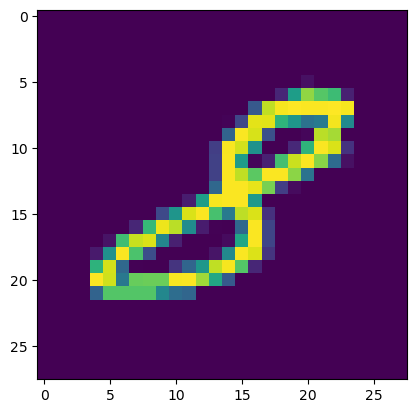

In [32]:
# 숫자 눈으로 뿌려보기
import matplotlib.pyplot as plt
plt.imshow(X_single_data.reshape(28,28).cpu())
print(Y_single_data)